## Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Tuple, Dict, Union, Optional
import pickle

## Decision Tree

In [3]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.gini = None
        self.gain = None

class DecisionTree:
    def __init__(self, max_depth: int, min_samples_split: int,
                 class_weight: Optional[Dict[int, float]] = None,
                 random_state: Optional[int] = None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.class_weight = class_weight
        self.random_state = random_state
        self.root = None
        self.n_classes = None
        self.feature_importances_ = None

        if random_state is not None:
            np.random.seed(random_state)

    def _calculate_weighted_gini(self, y: np.ndarray) -> float:
        if len(y) == 0:
            return 0.0

        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)

        if self.class_weight is not None:
            weights = np.array([self.class_weight.get(c, 1.0) for c in range(self.n_classes)])
            proportions = proportions * weights
            proportions = proportions / proportions.sum()

        return 1.0 - np.sum(proportions ** 2)

    def _split_data(self, X: np.ndarray, y: np.ndarray, feature: int,
                    threshold: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return (X[left_mask], X[right_mask],
                y[left_mask], y[right_mask])

    def _calculate_information_gain(self, y_parent: np.ndarray, y_left: np.ndarray,
                                  y_right: np.ndarray) -> float:
        n_left, n_right = len(y_left), len(y_right)
        n_parent = len(y_parent)

        if n_parent == 0:
            return 0.0

        gini_parent = self._calculate_weighted_gini(y_parent)
        gini_left = self._calculate_weighted_gini(y_left)
        gini_right = self._calculate_weighted_gini(y_right)

        w_left = n_left / n_parent
        w_right = n_right / n_parent

        return gini_parent - (w_left * gini_left + w_right * gini_right)

    def _find_best_split(self, X: np.ndarray, y: np.ndarray, feature_subset: Optional[List[int]] = None) -> Tuple[int, float, float]:
        best_gain = -float('inf')
        best_feature = None
        best_threshold = None
        eps = 1e-10

        features = (feature_subset if feature_subset is not None else range(X.shape[1]))
        n_samples = len(y)

        _, class_counts = np.unique(y, return_counts=True)
        proportions = class_counts / (n_samples + eps)
        gini_parent = 1.0 - np.sum(proportions ** 2)

        for feature in features:
            sorted_indices = np.argsort(X[:, feature])
            sorted_x = X[sorted_indices, feature]
            sorted_y = y[sorted_indices]

            unique_values = np.unique(sorted_x)

            if len(unique_values) < 2:
                continue

            thresholds = (unique_values[1:] + unique_values[:-1]) / 2

            for threshold in thresholds:
                left_mask = sorted_x <= threshold
                right_mask = ~left_mask

                y_left = sorted_y[left_mask]
                y_right = sorted_y[right_mask]

                if len(y_left) < self.min_samples_split or len(y_right) < self.min_samples_split:
                    continue

                _, left_counts = np.unique(y_left, return_counts=True)
                _, right_counts = np.unique(y_right, return_counts=True)

                n_left = len(y_left)
                n_right = len(y_right)

                left_proportions = left_counts / (n_left + eps)
                right_proportions = right_counts / (n_right + eps)

                gini_left = 1.0 - np.sum(left_proportions ** 2)
                gini_right = 1.0 - np.sum(right_proportions ** 2)

                gain = gini_parent - (n_left/n_samples * gini_left + n_right/n_samples * gini_right)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0,
                    feature_subset: Optional[List[int]] = None) -> DecisionTreeNode:
        n_samples = len(y)

        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            len(np.unique(y)) == 1):

            if self.class_weight is not None:
                counts = np.bincount(y, weights=[self.class_weight.get(yi, 1.0) for yi in y])
            else:
                counts = np.bincount(y)

            node = DecisionTreeNode(value=np.argmax(counts))
            node.gini = self._calculate_weighted_gini(y)
            return node

        best_feature, best_threshold, best_gain = self._find_best_split(
            X, y, feature_subset
        )

        if best_feature is None:
            node = DecisionTreeNode(value=Counter(y).most_common(1)[0][0])
            node.gini = self._calculate_weighted_gini(y)
            return node

        X_left, X_right, y_left, y_right = self._split_data(
            X, y, best_feature, best_threshold
        )

        node = DecisionTreeNode(
            feature=best_feature,
            threshold=best_threshold
        )

        node.gini = self._calculate_weighted_gini(y)
        node.gain = best_gain

        node.left = self._build_tree(X_left, y_left, depth + 1, feature_subset)
        node.right = self._build_tree(X_right, y_right, depth + 1, feature_subset)

        return node

    def fit(self, X: np.ndarray, y: np.ndarray,
            feature_subset: Optional[List[int]] = None) -> 'DecisionTree':
        y = y.astype(np.int32)
        self.n_classes = len(np.unique(y))

        if self.class_weight is None:
            class_counts = np.bincount(y)
            total = len(y)
            self.class_weight = {
                c: total / (self.n_classes * count)
                for c, count in enumerate(class_counts)
            }

        self.root = self._build_tree(X, y, feature_subset=feature_subset)
        self._calculate_feature_importance(X)
        return self

    def _traverse_tree(self, x: np.ndarray, node: DecisionTreeNode) -> int:
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _calculate_feature_importance(self, X: np.ndarray):
        self.feature_importances_ = np.zeros(X.shape[1])
        self._update_feature_importance(self.root, 1.0)

        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)

    def _update_feature_importance(self, node: DecisionTreeNode, weight: float):
        if node.feature is not None:
            self.feature_importances_[node.feature] += weight * (node.gain or 0)
            if node.left:
                self._update_feature_importance(node.left, weight * 0.5)
            if node.right:
                self._update_feature_importance(node.right, weight * 0.5)

## Random Forest

In [4]:
class RandomForest:
    def __init__(self, n_estimators: int, max_depth: int,
                 min_samples_split: int, max_features: Union[str, float] = 'sqrt',
                 random_state: Optional[int] = None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_importances_ = None
        self.n_features = None

        if random_state is not None:
            np.random.seed(random_state)

    def _bootstrap_sample(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def _get_feature_subset_size(self, n_features: int) -> int:
        if isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                return int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                return int(np.log2(n_features))
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        return n_features

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.n_features = X.shape[1]
        self.trees = []
        n_features_subset = self._get_feature_subset_size(self.n_features)

        print(f"\nTraining Random Forest with {self.n_estimators} trees...")
        print(f"Features per tree: {n_features_subset}/{self.n_features}")

        for i in range(self.n_estimators):
            if (i + 1) % 10 == 0:
                print(f"Training tree {i + 1}/{self.n_estimators}")

            X_sample, y_sample = self._bootstrap_sample(X, y)

            feature_subset = np.random.choice(
                self.n_features,
                size=n_features_subset,
                replace=False
            )

            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state + i if self.random_state else None
            )

            X_subset = X_sample[:, feature_subset]
            tree.fit(X_subset, y_sample)

            self.trees.append((tree, feature_subset))

        self._calculate_feature_importance()
        return self

    def _calculate_feature_importance(self):
        importances = np.zeros(self.n_features)
        counts = np.zeros(self.n_features)

        for tree, feature_subset in self.trees:
            for idx, feature in enumerate(feature_subset):
                if tree.feature_importances_ is not None:
                    importances[feature] += tree.feature_importances_[idx]
                    counts[feature] += 1

        mask = counts > 0
        importances[mask] /= counts[mask]

        if np.sum(importances) > 0:
            importances /= np.sum(importances)

        self.feature_importances_ = importances

    def predict(self, X: np.ndarray) -> np.ndarray:
        if X.shape[1] != self.n_features:
            raise ValueError(
                f"Number of features in prediction data ({X.shape[1]}) "
                f"does not match training data ({self.n_features})"
            )

        predictions = np.zeros((len(X), self.n_estimators))

        for i, (tree, feature_subset) in enumerate(self.trees):
            X_subset = X[:, feature_subset]
            predictions[:, i] = tree.predict(X_subset)

        return np.array([
            Counter(row).most_common(1)[0][0]
            for row in predictions
        ])

    def get_feature_importance_plot(self, feature_names=None):
        if self.feature_importances_ is None:
            raise ValueError("No feature importances available. Model must be trained first.")

        importances = self.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')

        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(len(importances))]

        plt.bar(range(len(importances)),
                importances[indices],
                align='center')
        plt.xticks(range(len(importances)),
                   [feature_names[i] for i in indices],
                   rotation=45)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()

## Features Engineering

In [5]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df_engineered = df.copy()

    df_engineered['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
    df_engineered['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

    eps = 1e-10
    df_engineered['balance_ratio_orig'] = (df['newbalanceOrig'] + eps) / (df['oldbalanceOrg'] + eps)
    df_engineered['balance_ratio_dest'] = (df['newbalanceDest'] + eps) / (df['oldbalanceDest'] + eps)

    df_engineered['error_balance_orig'] = df['amount'] - (df['oldbalanceOrg'] - df['newbalanceOrig'])
    df_engineered['error_balance_dest'] = df['amount'] - (df['newbalanceDest'] - df['oldbalanceDest'])

    df_engineered['amount_ratio_orig'] = df['amount'] / (df['oldbalanceOrg'] + eps)
    df_engineered['amount_ratio_dest'] = df['amount'] / (df['oldbalanceDest'] + eps)

    df_engineered['zero_balance_orig'] = ((df['oldbalanceOrg'] == 0) | (df['newbalanceOrig'] == 0)).astype(int)
    df_engineered['zero_balance_dest'] = ((df['oldbalanceDest'] == 0) | (df['newbalanceDest'] == 0)).astype(int)
    df_engineered['full_transfer'] = (df['newbalanceOrig'] == 0).astype(int)
    df_engineered['balance_mismatch'] = (abs(df['oldbalanceOrg'] - df['newbalanceOrig']) != df['amount']).astype(int)

    df_engineered['hour'] = df['step'] % 24
    df_engineered['day'] = df['step'] // 24

    df_engineered['dest_is_merchant'] = (df['nameDest'].str.startswith('M')).astype(int)

    return df_engineered

## Pre-Processing

In [19]:
def preprocess_data(df: pd.DataFrame, sampling_strategy: str, use_feature_engineering: bool) -> Tuple[np.ndarray, np.ndarray]:
    if use_feature_engineering:
        df = engineer_features(df)

    base_features = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                    'oldbalanceDest', 'newbalanceDest']

    if use_feature_engineering:
        additional_features = [
            'balance_diff_orig', 'balance_diff_dest',
            'balance_ratio_orig', 'balance_ratio_dest',
            'error_balance_orig', 'error_balance_dest',
            'amount_ratio_orig', 'amount_ratio_dest',
            'zero_balance_orig', 'zero_balance_dest',
            'full_transfer', 'balance_mismatch',
            'hour', 'day', 'dest_is_merchant'
        ]
        features = base_features + additional_features
    else:
        features = base_features

    categorical_features = ['type']
    df_encoded = pd.get_dummies(df[features], columns=categorical_features)

    X = df_encoded.values.astype(np.float64)
    y = df['isFraud'].values.astype(np.int32)

    for i in range(X.shape[1]):
        mean_val = np.mean(X[:, i])
        std_val = np.std(X[:, i])
        if std_val != 0:
            X[:, i] = (X[:, i] - mean_val) / std_val
        else:
            X[:, i] = X[:, i] - mean_val

    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    if sampling_strategy != 'none':
        X, y = handle_imbalanced_data(X, y, sampling_strategy)

    y = y.astype(np.int32)

    return X, y

def handle_imbalanced_data(X: np.ndarray, y: np.ndarray, strategy: str) -> Tuple[np.ndarray, np.ndarray]:
    print(f"\nOriginal dataset composition:")
    print(f"Fraud transactions: {np.sum(y == 1)}")
    print(f"Non-fraud transactions: {np.sum(y == 0)}")
    ratio = np.sum(y == 0) / (np.sum(y == 1) + 1e-10)
    print(f"Ratio fraud:non-fraud = 1:{ratio:.2f}")

    fraud_indices = np.where(y == 1)[0]
    non_fraud_indices = np.where(y == 0)[0]

    n_fraud = len(fraud_indices)
    n_non_fraud = len(non_fraud_indices)

    if strategy == 'undersample':
        target_non_fraud = min(n_fraud * 10, n_non_fraud)
        selected_non_fraud_indices = np.random.choice(
            non_fraud_indices,
            size=target_non_fraud,
            replace=False
        )
        selected_indices = np.concatenate([fraud_indices, selected_non_fraud_indices])

    elif strategy == 'oversample':
        target_fraud = n_non_fraud // 10
        fraud_indices_oversampled = np.random.choice(
            fraud_indices,
            size=target_fraud,
            replace=True
        )
        selected_indices = np.concatenate([fraud_indices_oversampled, non_fraud_indices])

    elif strategy == 'combine':
        target_ratio = 3
        if n_non_fraud / n_fraud > target_ratio:
            target_non_fraud = n_fraud * target_ratio
            selected_non_fraud_indices = np.random.choice(
                non_fraud_indices,
                size=int(target_non_fraud),
                replace=False
            )
            target_fraud = int(target_non_fraud / target_ratio * 1.2)  
            fraud_indices_oversampled = np.random.choice(
                fraud_indices,
                size=target_fraud,
                replace=True
            )
            selected_indices = np.concatenate([fraud_indices_oversampled, selected_non_fraud_indices])
        else:
            return X, y  

    elif strategy == 'smote':
        try:
            from sklearn.preprocessing import StandardScaler
            from imblearn.over_sampling import SMOTENC
            
            categorical_features = []
            for i in range(X.shape[1]):
                if len(np.unique(X[:, i])) <= 2:  
                    categorical_features.append(i)
            
            scaler = StandardScaler()
            X_scaled = X.copy()
            numerical_features = list(set(range(X.shape[1])) - set(categorical_features))
            X_scaled[:, numerical_features] = scaler.fit_transform(X[:, numerical_features])
            
            smote = SMOTENC(
                categorical_features=categorical_features,
                sampling_strategy=0.1,  
                k_neighbors=min(5, len(fraud_indices)-1),
                random_state=42
            )
            X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
            
            X_resampled[:, numerical_features] = scaler.inverse_transform(
                X_resampled[:, numerical_features]
            )
            
            print("\nAfter SMOTE resampling:")
            print(f"Fraud transactions: {np.sum(y_resampled == 1)}")
            print(f"Non-fraud transactions: {np.sum(y_resampled == 0)}")
            return X_resampled, y_resampled
            
        except ImportError:
            print("Warning: SMOTE requires imbalanced-learn package. Falling back to combine strategy.")
            return handle_imbalanced_data(X, y, 'combine')
        except Exception as e:
            print(f"Error applying SMOTE: {str(e)}. Falling back to combine strategy.")
            return handle_imbalanced_data(X, y, 'combine')

    if strategy != 'smote':
        X_resampled = X[selected_indices]
        y_resampled = y[selected_indices]
        print("\nAfter resampling:")
        print(f"Fraud transactions: {np.sum(y_resampled == 1)}")
        print(f"Non-fraud transactions: {np.sum(y_resampled == 0)}")
        new_ratio = np.sum(y_resampled == 0) / (np.sum(y_resampled == 1) + 1e-10)
        print(f"New ratio fraud:non-fraud = 1:{new_ratio:.2f}")
        return X_resampled, y_resampled

    return X, y

## Evaluate Model

In [13]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_accuracy = (recall + specificity) / 2

    g_mean = np.sqrt(recall * specificity) if (recall * specificity) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'balanced_accuracy': balanced_accuracy,
        'g_mean': g_mean
    }

## Plot Confusion Matrix

In [14]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str = "Confusion Matrix"):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    confusion_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    thresh = confusion_matrix.max() / 2
    for i, j in np.ndindex(confusion_matrix.shape):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    classes = ['Not Fraud', 'Fraud']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()

## Plot ROC Curve

In [15]:
def plot_roc_curve(y_true: np.ndarray, y_prob: np.ndarray, title: str = "ROC Curve"):
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## Plot Features Important

In [16]:
def plot_feature_importance(model, feature_names: List[str], title: str = "Feature Importance"):
    importances = model.feature_importances_

    indices = np.argsort(importances)[::-1]

    plt.title(title)
    plt.bar(range(len(importances)),
            importances[indices],
            color='royalblue')

    plt.xticks(range(len(importances)),
               [feature_names[i] for i in indices],
               rotation=45,
               ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

# Controller

Loading data...

Preprocessing data...

Original dataset composition:
Fraud transactions: 8213
Non-fraud transactions: 30000
Ratio fraud:non-fraud = 1:3.65

After resampling:
Fraud transactions: 9855
Non-fraud transactions: 24639
New ratio fraud:non-fraud = 1:2.50

Splitting data...

Training Decision Tree...

Training Random Forest...

Training Random Forest with 20 trees...
Features per tree: 5/25
Training tree 10/20
Training tree 20/20

Model Evaluation Results:

Decision Tree:
accuracy: 0.9991
precision: 1.0000
recall: 0.9970
f1_score: 0.9985
specificity: 1.0000
balanced_accuracy: 0.9985
g_mean: 0.9985

Random Forest:
accuracy: 0.9978
precision: 0.9950
recall: 0.9975
f1_score: 0.9963
specificity: 0.9980
balanced_accuracy: 0.9977
g_mean: 0.9977


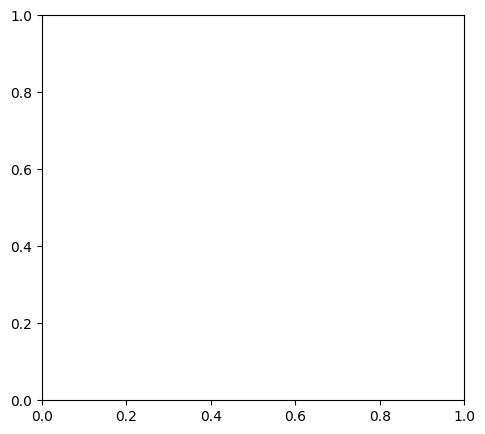

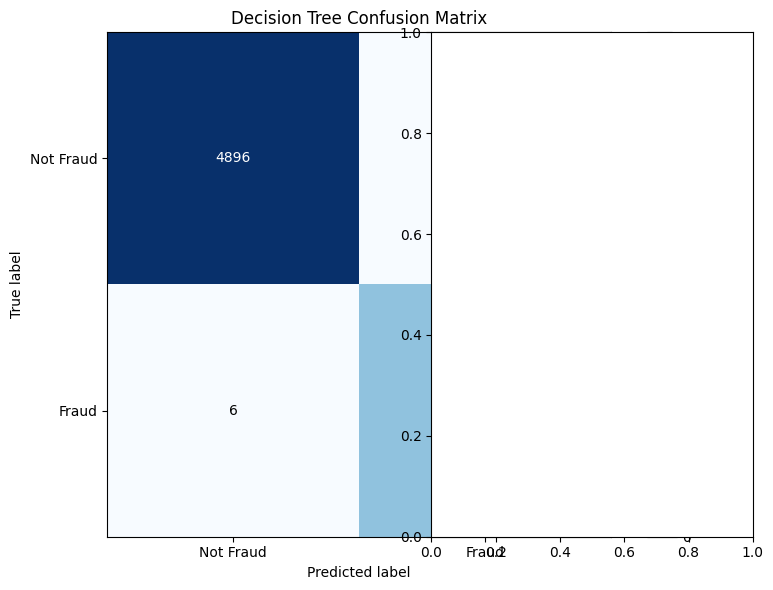

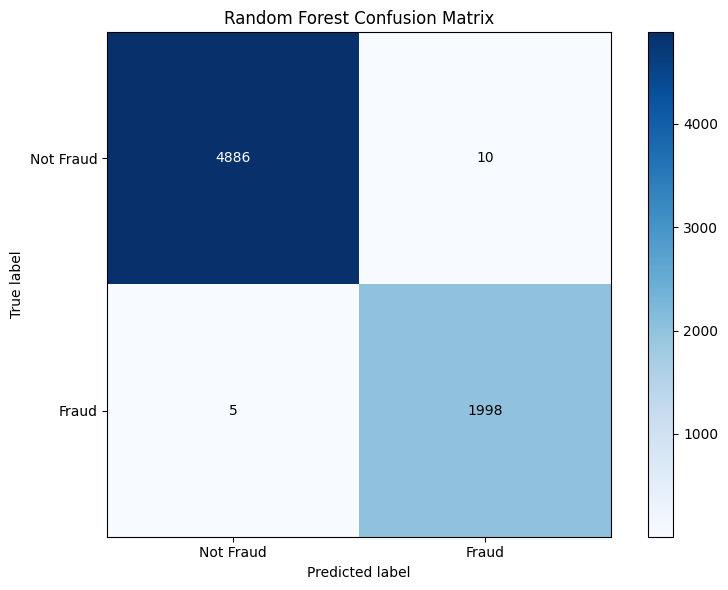

An error occurred: list index out of range


Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Temp\ipykernel_8236\274589556.py", line 83, in <module>
    plot_feature_importance(dt, feature_names, "Decision Tree Feature Importance")
  File "C:\Users\user\AppData\Local\Temp\ipykernel_8236\1821850015.py", line 12, in plot_feature_importance
    [feature_names[i] for i in indices],
     ~~~~~~~~~~~~~^^^
IndexError: list index out of range


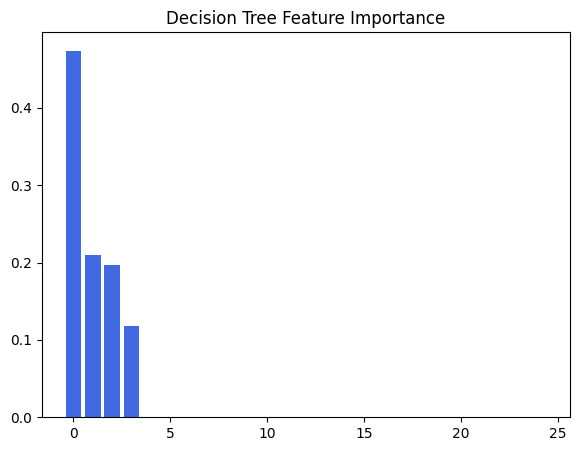

In [21]:
def sampling_dataset(df, sample_size):
    isFraud = df[df['isFraud'] == 1]
    nonFraud = df[df['isFraud'] == 0]

    sampling_df = pd.concat([isFraud, nonFraud.sample(n=sample_size, random_state=2)])

    return sampling_df.sample(frac=1, random_state=2).reset_index(drop=True)


try:
    print("Loading data...")
    df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
    df = sampling_dataset(df, 30000)

    print("\nPreprocessing data...")
    X, y = preprocess_data(df, sampling_strategy='combine', use_feature_engineering=True)

    print("\nSplitting data...")
    indices = np.random.permutation(len(X))
    train_size = int(0.8 * len(X))

    X_train = X[indices[:train_size]]
    y_train = y[indices[:train_size]]
    X_test = X[indices[train_size:]]
    y_test = y[indices[train_size:]]

    print("\nTraining Decision Tree...")
    dt = DecisionTree(max_depth=5, min_samples_split=5)
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_test)

    print("\nTraining Random Forest...")
    rf = RandomForest(
        n_estimators=20,
        max_depth=5,
        min_samples_split=5,
        max_features='sqrt',
        random_state=808
    )
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    with open('decision_tree_model.pkl', 'wb') as f:
        pickle.dump(dt, f)

    with open('random_forest_model.pkl', 'wb') as f:
        pickle.dump(rf, f)

    print("\nModel Evaluation Results:")
    print("\nDecision Tree:")
    dt_metrics = evaluate_model(y_test, dt_pred)
    for metric, value in dt_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nRandom Forest:")
    rf_metrics = evaluate_model(y_test, rf_pred)
    for metric, value in rf_metrics.items():
        print(f"{metric}: {value:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plot_confusion_matrix(y_test, dt_pred, "Decision Tree Confusion Matrix")

    plt.subplot(1, 2, 2)
    plot_confusion_matrix(y_test, rf_pred, "Random Forest Confusion Matrix")

    plt.tight_layout()
    plt.show()

    feature_names = list(pd.get_dummies(
        df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest']],
        columns=['type']
    ).columns)

    with open('feature_names.pkl', 'wb') as f:
        pickle.dump(feature_names, f)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plot_feature_importance(dt, feature_names, "Decision Tree Feature Importance")

    plt.subplot(1, 2, 2)
    plot_feature_importance(rf, feature_names, "Random Forest Feature Importance")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
